In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee
import corner
import h5py
import os
import os.path as osp
from tqdm.notebook import tqdm

# === USER INPUTS ===
backend_dir =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/")  # <- replace with your emcee backend file
files = [f for f in os.listdir(backend_dir) if 'run' and 'C2v' and 'bc_run' in f]
files = [f for f in files if 'temp' not in f]
files

['bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update_noalpha.h5',
 'bc_run_SymmetryC2v_BCTrue_F1p0_DFalse_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_update.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_trunc_test.h5',
 'bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_BC_hierarchy.h5',
 'bc_run_SymmetryC2v_BCFalse_F1p0_DFalse_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_test.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p0001_update_notau_noalpha.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_update.h5',
 'bc_run_SymmetryC2v_BCTrue_F1p1_DTrue_FlatFalse_SpecTrue_dTTrue_covFa

In [2]:
files = [f for f in files if 'update' in f]
files = [f for f in files if 'tau' in f]

files

['bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update_noalpha.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p0001_update_notau_noalpha.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryC2v_BCTrue_F1p0_DFalse_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryCs_BCFalse_F1p0_DFalse_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryC2v_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse_nonlinFalse_tauSlope0p05_update.h5',
 'bc_run_SymmetryCs_BCFalse_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_ta

bc_run_SymmetryCs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_nonlinFalse_tauSlope0p0001_update_notau_noalpha.h5
Loaded backend with 64 walkers and 7713 steps.
Autocorrelation times (steps): [517.67744036 519.98803982 359.2983387  404.18166015 234.63526899
 226.42648148 478.27259296  43.9712514 ]


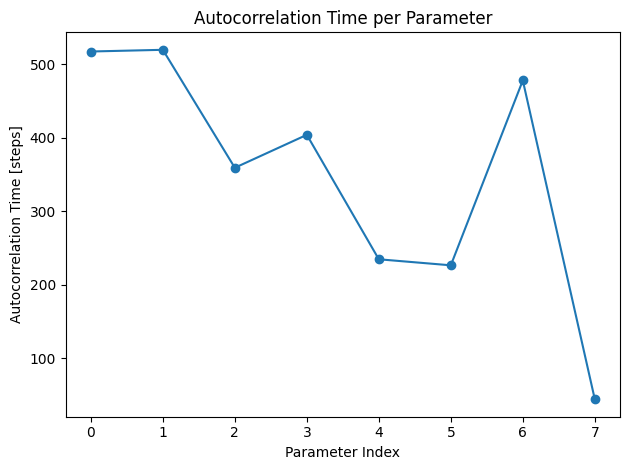

In [3]:
idx = 2
f = files[idx]
backend_file = backend_dir+f
print(f)
# backend_file = backend_dir+'full_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5'
# backend_file = backend_dir+'full_run_Cs_ATrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_AFalse_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTFalse_covTrue.h5'
# backend_file = backend_dir+'full_run.h5'
discard = 0  # number of burn-in steps to discard
thin = 10      # thinning factor for chains
flat = True    # whether to flatten the chain
max_autocorr_steps = 100  # how far to try computing autocorr
# ====================

# Load the backend
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
n_steps, n_walkers, n_dim = backend.get_chain().shape
print(f"Loaded backend with {n_walkers} walkers and {n_steps} steps.")

# Check if there's enough data
if n_steps < 2 * discard:
    raise RuntimeError("Too few samples to discard burn-in.")

# Compute autocorrelation time
try:
    tau = backend.get_autocorr_time(tol=0, discard=discard)
    print("Autocorrelation times (steps):", tau)
except emcee.autocorr.AutocorrError:
    print("WARNING: Autocorrelation time could not be reliably estimated. Showing partial results.")
    tau = None

# Plot autocorrelation estimate per parameter (if possible)
if tau is not None:
    fig, ax = plt.subplots()
    ax.plot(tau, "o-")
    ax.set_xlabel("Parameter Index")
    ax.set_ylabel("Autocorrelation Time [steps]")
    ax.set_title("Autocorrelation Time per Parameter")
    plt.tight_layout()
    plt.show()

Loaded backend with 64 walkers, 7713 steps, 8 dimensions.


  0%|          | 0/77 [00:00<?, ?it/s]

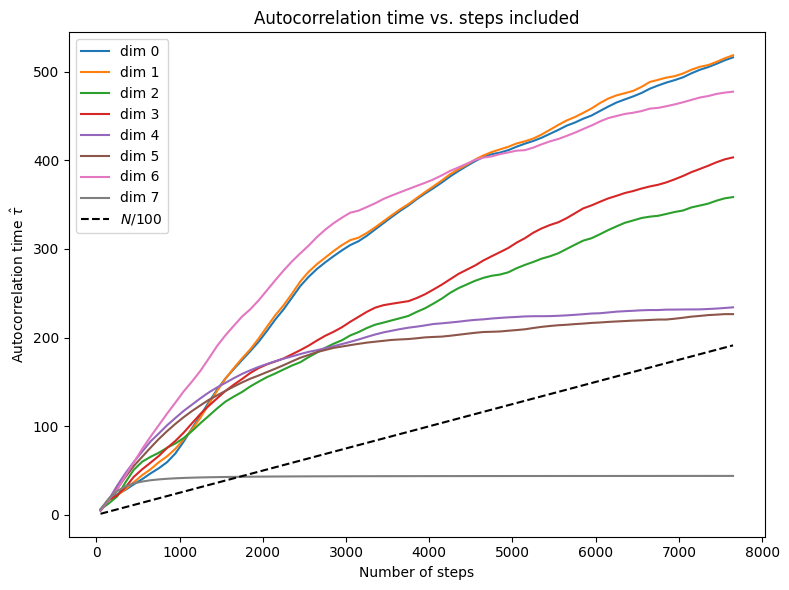

In [4]:
discard = 0
thin = 1
step_stride = 100
min_steps = 50

# ====================

# Load backend and chain
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
full_chain = backend.get_chain(discard=discard, thin=thin)
n_steps, n_walkers, n_dim = full_chain.shape
max_steps = n_steps+100
print(f"Loaded backend with {n_walkers} walkers, {n_steps} steps, {n_dim} dimensions.")

# Limit the max_steps to what's available
max_steps = min(max_steps, n_steps)

# Storage
all_taus = []
step_list = []

# Loop over truncated chains
for n in tqdm( range(min_steps, max_steps + 1, step_stride) ):
    truncated = full_chain[:n]  # shape (n, n_walkers, n_dim)
    try:
        tau = emcee.autocorr.integrated_time(truncated, tol=0)
        all_taus.append(tau)
        step_list.append(n)
    except emcee.autocorr.AutocorrError:
        print(f"Step {n}: autocorr failed")
        continue

# Convert to arrays
all_taus = np.array(all_taus)  # shape (num_points, ndim)
step_list = np.array(step_list)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_dim):
    ax.plot(step_list, all_taus[:, i], label=f"dim {i}")
ax.plot(step_list, step_list / 40, "--k", label=r"$N/100$")

ax.set_xlabel("Number of steps")
ax.set_ylabel(r"Autocorrelation time $\hat{\tau}$")
ax.set_title("Autocorrelation time vs. steps included")
ax.legend()
plt.tight_layout()
plt.show()


In [16]:
backend_dir =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/")  # <- replace with your emcee backend file
files = [f for f in os.listdir(backend_dir) if 'temp' not in f]
files = [f for f in files if 'update' in f]
files = [f for f in files if 'Slope' in f]
files = [f for f in files if 'C2v' in f]
files = [f for f in files if 'dTFalse' in f]

files

['bc_run_SymmetryC2v_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse_nonlinFalse_tauSlope0p05_update.h5']

In [23]:
mpl.rcParams.update(mpl.rcParamsDefault)
idx = 0
filename = files[idx]
f = filename
backend_file = backend_dir+filename
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
full_chain = backend.get_chain(discard=discard, thin=thin)
n_steps, n_walkers, n_dim = full_chain.shape
print(f"Loaded backend with {n_walkers} walkers, {n_steps} steps, {n_dim} dimensions.")

Loaded backend with 64 walkers, 3258 steps, 8 dimensions.


/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/corner/core.py:921: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)
/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/corner/core.py:921: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)
/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/corner/core.py:921: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)
/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/corner/core.py:928: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)


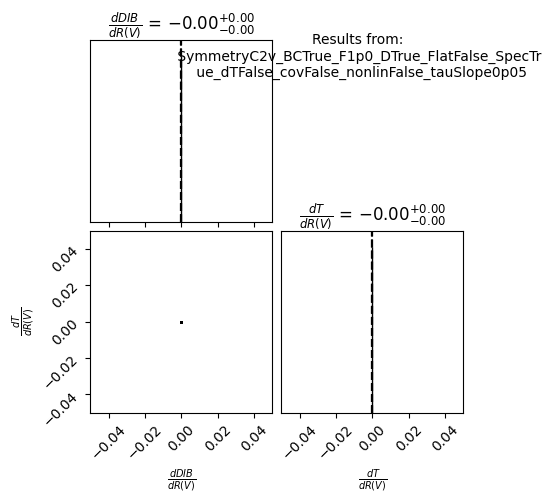

In [18]:
raw = False
correct_r_bc = False
asize = 2.5
cRV = 0.3
deltaT = 0.05
if raw:
    discard = int( 3*np.mean(all_taus[-1, :]) )
    if discard > n_steps:
        discard = n_steps//2
    blobs = backend.get_blobs(discard=discard, thin=thin, flat=flat)
    _, n_dim_blob = blobs.shape
    fig, axs = plt.subplots(n_dim_blob, n_dim_blob, figsize = ( asize * n_dim_blob, asize * n_dim_blob )) 
    labels = [r'$\gamma$', r'r$_{\mathrm{bc}}$', r'$c_{\mathrm{spec}}$', r'$\alpha$', r'$\beta$', r'$c_{\mathrm{\Delta T}}$']
    # Corner plot
    fig = corner.corner(
        blobs,
        labels=labels,
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.999]*len(labels),
        fig = fig
    )

if not raw:
    discard = int( 3*np.mean(all_taus[-1, :]) )
    if discard > n_steps:
        discard = n_steps//2
    blobs = backend.get_blobs(discard=discard, thin=thin, flat=flat)
    n_dim_blob = 2
    fig, axs = plt.subplots(n_dim_blob, n_dim_blob, figsize = ( asize * n_dim_blob, asize * n_dim_blob )) 
    labels = [r'$\frac{dDIB}{dR(V)} = \frac{\alpha}{c_{R(V)} \cdot \gamma}$',\
              r'$\frac{dR(V)}{dT} = \frac{\beta}{\Delta T \cdot c_{R(V)}}$', r'ratio$_{\mathrm{bc}}$']

    labels = [r'$\frac{dDIB}{dR(V)}$', r'$\frac{dT}{dR(V)}$']

    # Corner plot
    phys_vals = np.vstack([ blobs[:,3]/(blobs[:,0]*cRV), deltaT*blobs[:,4]/(blobs[:,0]*cRV)]).T
    fig = corner.corner(
        phys_vals,
        labels=labels,
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".2f",
        range = [0.999]*len(labels),
        fig = fig
    )

if len(f) < 109:
    title = f'\n {f[7:len(f)//2]} \n {f[len(f)//2:-10]}'
else:
    title = f'\n {f[7:len(f)//3]} \n {f[len(f)//3:2*len(f)//3]} \n {f[2*len(f)//3:-3]}'
    
fig.suptitle(f'Results from: {title}', y = 0.94, x = 0.72, fontsize = 10)
fig

Samples shape: (208512, 8)


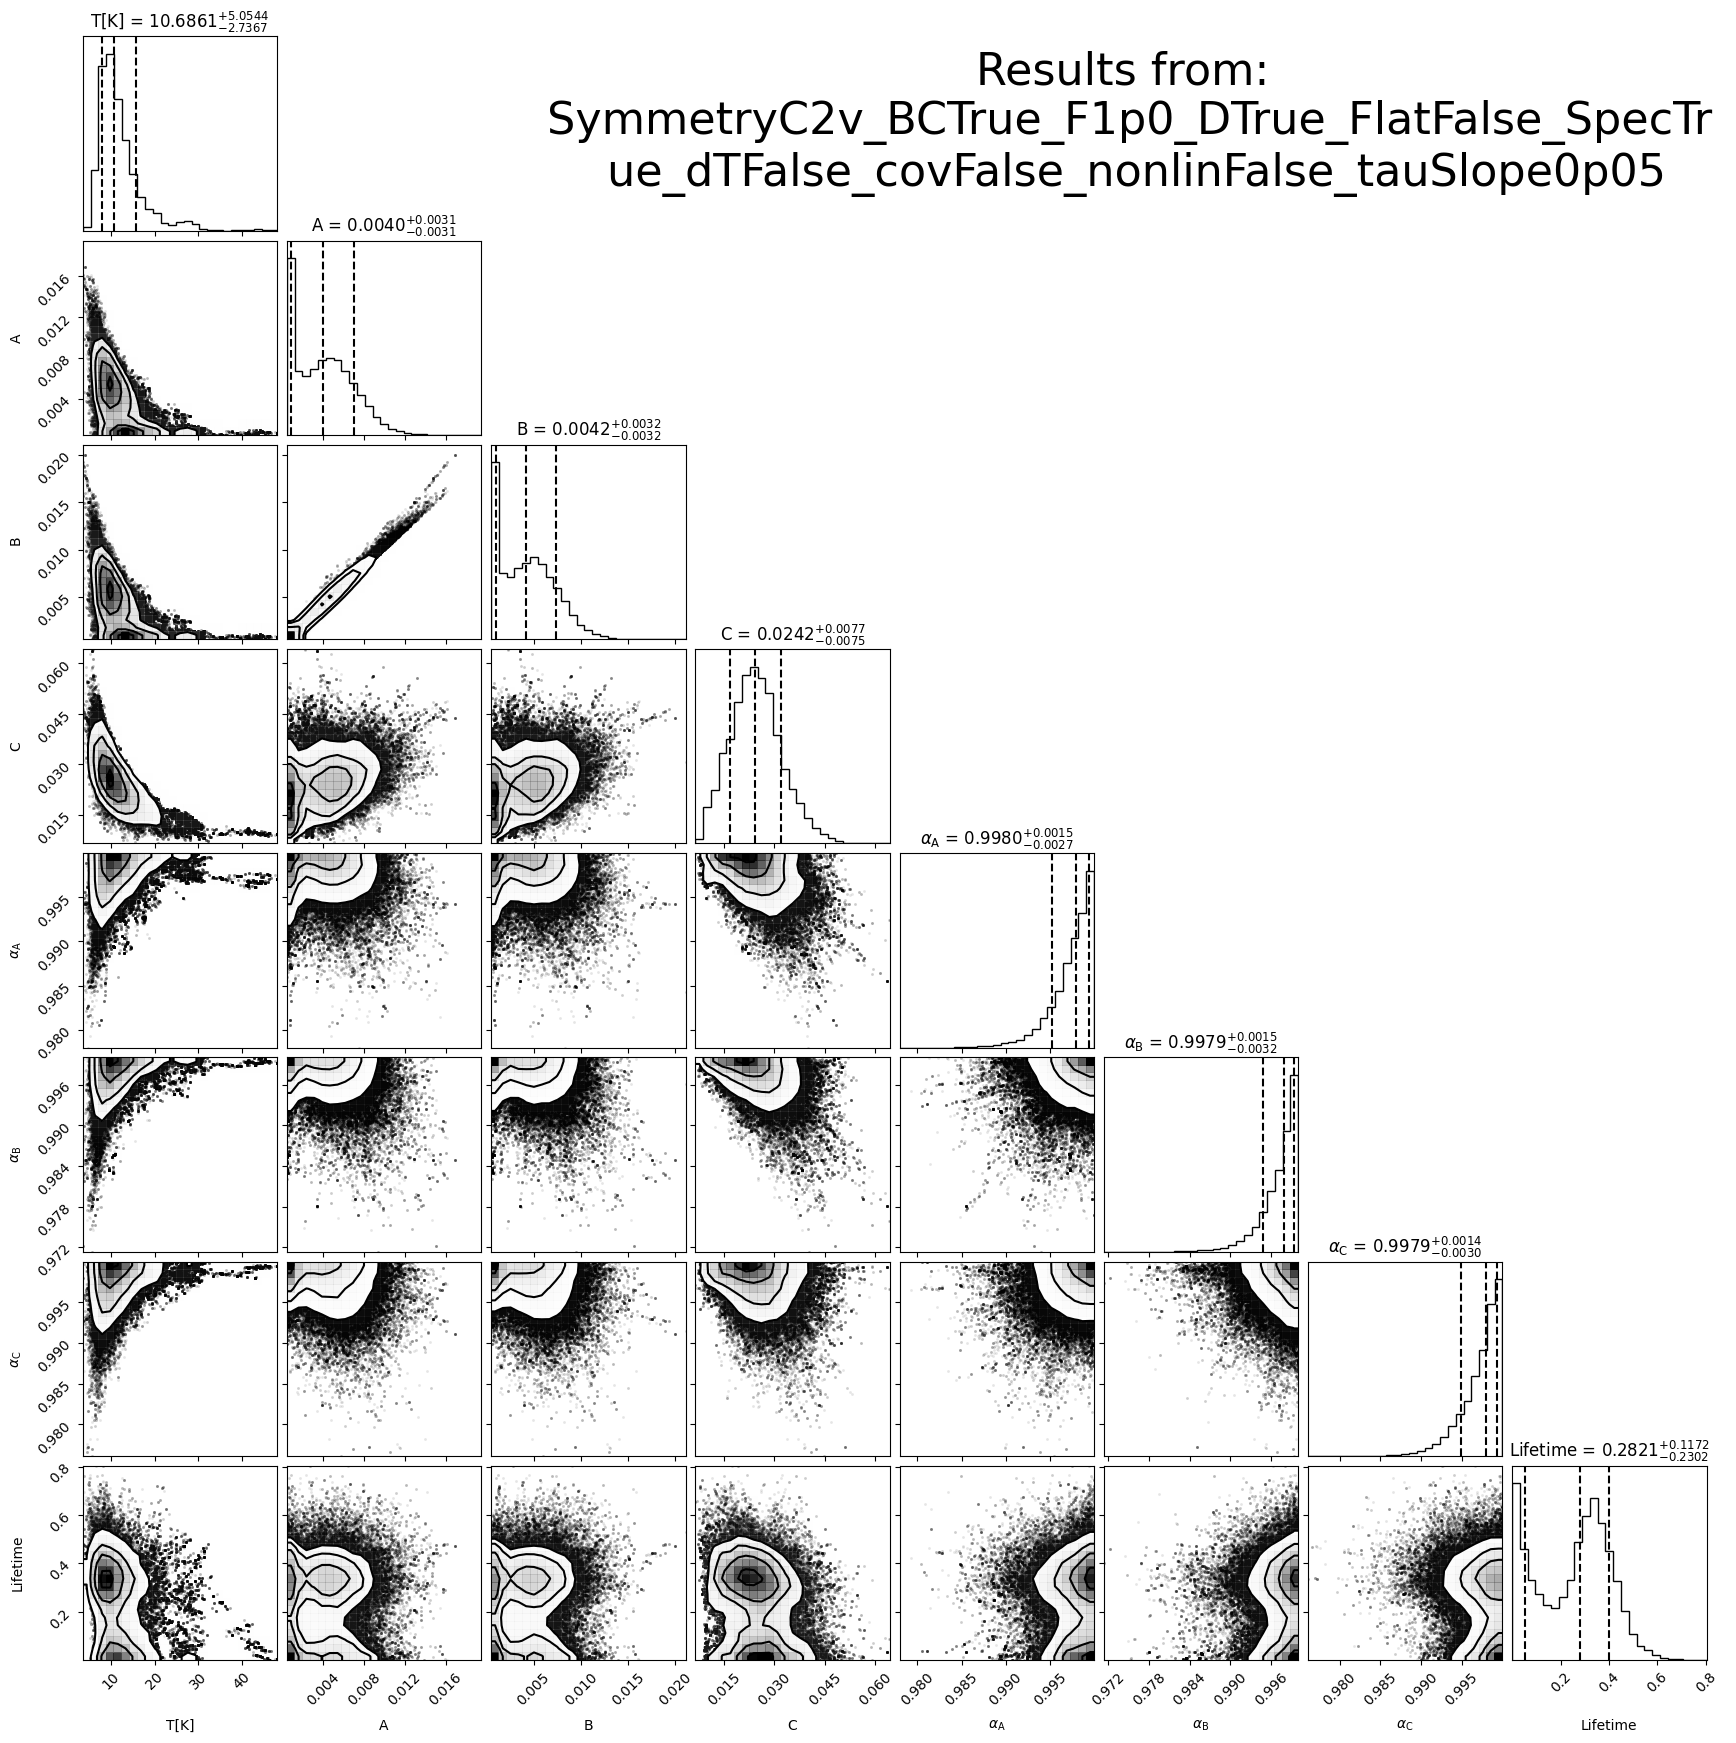

In [24]:
asize = 2.2
cut_stuck = False

T_fac = 1.2
if n_dim == 6:
    # Extract samples
    fig, axs = plt.subplots(n_dim, n_dim, figsize = ( asize * n_dim, asize * n_dim )) 
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    if discard > n_steps:
        discard = n_steps//2
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)
    if cut_stuck:
        samples = samples[samples[:,0]<15] # two stuck walkers
    
    print(f"Samples shape: {samples.shape}")
    if T_fac:
        samples[:,0]*=T_fac
    # labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T[K]']
    labels = ['T[K]', '$\\mathrm{AB}$', '$\\mathrm{C}$', '$\\alpha_{\\mathrm{AB}}$', '$\\alpha_{\\mathrm{C}}$', r'Lifetime']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels,
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels),
        fig = fig
    )


if n_dim == 8:
    # Extract samples
    fig, axs = plt.subplots(n_dim, n_dim, figsize = ( asize * n_dim, asize * n_dim )) 
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    if discard > n_steps:
        discard = n_steps//2
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)
    if cut_stuck:
        samples = samples[samples[:,0]<15] # two stuck walkers
    # samples_ext = samples[samples[:,0]>10]
    # samples = np.vstack([samples, samples_ext, samples_ext, samples_ext])
    print(f"Samples shape: {samples.shape}")
    if T_fac:
        samples[:,0]*=T_fac
    labels = ['T[K]', '$\\mathrm{A}$', '$\\mathrm{B}$', '$\\mathrm{C}$', '$\\alpha_{\\mathrm{A}}$', '$\\alpha_{\\mathrm{B}}$', '$\\alpha_{\\mathrm{C}}$', r'Lifetime']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels,
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels),
        fig = fig
    )

if len(f) < 109:
    title = f'\n {f[7:len(f)//2]} \n {f[len(f)//2:-10]}'
else:
    title = f'\n {f[7:len(f)//3]} \n {f[len(f)//3:2*len(f)//3]} \n {f[2*len(f)//3:-3]}'
    
fig.suptitle(f'Results from: {title}', y = 0.97, x = 0.65, fontsize = 24*(n_dim/6))
plt.show()

In [25]:
import pandas as pd

fudge = 1
DIB_15272 = h5py.File('new_errs/res_dib_15272.h5', "r")
data_wavelength = DIB_15272['wav'][:]
data_flux = DIB_15272['mean'][:][:,0]
data_flux_dT = DIB_15272['mean'][:][:,1]

noise_std = fudge*np.sqrt(DIB_15272['var'][:][:,0])
noise_std_dT = fudge*np.sqrt(DIB_15272['var'][:][:,1])

# errs0 = h5py.File(osp.expanduser('~/DIB/jackknife_dib.h5'), "r")
# measurements = pd.read_csv(osp.expanduser('~/DIB/pca_version.txt'), sep='\s+', names=['wavelength', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2'])
# data_wavelength = np.array( measurements['wavelength'] )
# data_flux = measurements['PC1_1'].values
# data_flux_dT = measurements['PC2_2'].values
# noise_std = fudge * np.sqrt(errs0['var'][:, 0])
# noise_std_dT = np.sqrt(errs0['var'][:, 1])

In [26]:
from multiprocessing import get_context
import subprocess, os, emcee, time, shutil, h5py, argparse
from scipy.ndimage import gaussian_filter
import numpy as np
import os.path as osp
from pathlib import Path
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.interpolate import interp1d

# Constants
PGO_TEMPLATE = osp.expanduser("~/DIB/pgo_files/asym_top_15272_C2v.pgo")

def filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C, lorentz_width=0.01, axis = 'b'):
    return f"T{T:.3f}_A{A_base:.7f}_B{B_base:.7f}_C{C_base:.7f}_FA{frac_A:.5f}_FB{frac_B:.5f}_FC{frac_C:.5f}_ax{axis}_lifetime{lorentz_width:.3f}"

def generate_pgopher_input_C2v(T, A_base, B_base, C_base, frac_A, frac_B, frac_C,
                              lorentz_width=0.01, axis="a"):
    A_g, B_g, C_g = A_base, B_base, C_base
    A_e, B_e, C_e = A_base * frac_A, B_base * frac_B, C_base * frac_C

    base = filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C, axis=axis)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" \\
        -v axis="{axis}" -v lorentz_width="{lorentz_width}" '
    BEGIN {{
        in_ground = 0; in_excited = 0;
    }}
    /<AsymmetricTop Name="v=0"/ {{
        in_ground = 1;
    }}
    /<AsymmetricTop Name="v=1"/ {{
        in_excited = 1;
    }}
    /<\/AsymmetricTop>/ {{
        in_ground = 0;
        in_excited = 0;
    }}
    in_ground && /<Parameter Name="A" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"")
    }}
    in_ground && /<Parameter Name="B" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"")
    }}
    in_ground && /<Parameter Name="C" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"")
    }}
    in_excited && /<Parameter Name="A" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"")
    }}
    in_excited && /<Parameter Name="B" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"")
    }}
    in_excited && /<Parameter Name="C" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"")
    }}
    /<CartesianTransitionMoment Bra="v=1" Ket="v=0"/ {{
        sub(/Axis="[^"]+"/, "Axis=\\"" axis "\\"")
    }}
    /<Parameter Name="Temperature" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<Parameter Name="Lorentzian" Value=/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" lorentz_width "\\"")
    }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")
    subprocess.run([osp.expanduser("~/DIB/./pgo"), "--plot", pgo_file, spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base


generate_pgopher_input = generate_pgopher_input_C2v

def convolve_pgopher_spectrum(spectrum_file, center_wav, lsf_key='LCO+APO', dlam=0.01, window=8):
    """
    Convolve PGOPHER output using LSF evaluated on a regular wavelength grid.

    Parameters:
        spectrum_file (str): PGOPHER output file with [wavenumber (1/cm), flux].
        center_wav (float): Central wavelength for the LSF (Å).
        lsf_key (str): Instrument profile selector (placeholder).
        dlam (float): Spacing (Å) for the regular wavelength grid.
        window (float): Half-width (Å) of the wavelength region to define the regular grid.

    Returns:
        wav_lsf (np.ndarray): Wavelength grid used for final output.
        flux_on_lsf_grid (np.ndarray): Flux convolved and resampled to wav_lsf.
        lsf_kernel (np.ndarray): LSF evaluated on regular grid.
        wav_pgo (np.ndarray): Original PGOPHER wavelength grid.
        convolved_flux (np.ndarray): Full-resolution convolved flux (on regular grid).
    """
    # === Load PGOPHER spectrum ===
    inv_cm, flux = np.loadtxt(spectrum_file).T
    wav_pgo = 1e8 / inv_cm

    wavc = 15272.27178113337
    # === Define regular wavelength grid around center ===
    wav_reg = np.arange(wavc - window, wavc + window, dlam)

    # === Interpolate PGOPHER flux onto this regular grid ===
    flux_interp = interp1d(wav_pgo, flux, bounds_error=False, fill_value=0.0)
    flux_reg = flux_interp(wav_reg)

    # === Construct LSF kernel on regular grid ===
    sig1 = 0.3
    sig2 = 1.85 * sig1
    sig3 = 9.5 * sig1
    f1 = 0.895
    f2 = 0.1
    c0 = 1.3e-3

    rel_grid = wav_reg - wavc  # Center the kernel
    p1 = 1/np.sqrt(2*np.pi*sig1**2)*np.exp( - rel_grid**2 / (2 * sig1**2) )
    p2 = 1/np.sqrt(2*np.pi*sig2**2)*np.exp( - rel_grid**2 / (2 * sig2**2) )
    p3 = 1/np.sqrt(2*np.pi*sig3**2)*np.exp( - rel_grid**2 / (2 * sig3**2) )

    lsf_kernel = f1 * p1 + f2 * p2 + (1 - f1 - f2) * p3 + c0
    lsf_kernel /= np.sum(lsf_kernel)

    # === Convolve on regular grid ===
    convolved_flux = convolve(flux_reg, lsf_kernel, mode='same')

    # === Interpolate back to original PGOPHER (or LSF) grid ===
    out_interp = interp1d(wav_reg, convolved_flux, bounds_error=False, fill_value=0.0)

    if args.use_direct:
        lsf_file = osp.expanduser('~/DIB/LSFs/lsf_15272.h5')
        # Load LSF and its wavelength grid
        with h5py.File(lsf_file, 'r') as f:
            wav_load = f['wav'][:]
        
    else:
        measurements = pd.read_csv(osp.expanduser('~/DIB/pca_version.txt'), sep='\s+', names=['wavelength', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2'])
        wav_load = measurements['wavelength']
    flux_on_lsf_grid = out_interp(wav_load)

    return wav_load, flux_on_lsf_grid


def log_prior_C2v(params):
    if args.B_not_equal_C:
        if len(params) != 8:
            return -np.inf
        T, A, B, C, frac_A, frac_B, frac_C, lorentz_width  = params
    else:
        if len(params) != 6:
            return -np.inf
        T, A, C, frac_A, frac_C, lorentz_width = params
        B = A
        frac_B = frac_A

    if args.flat_prior:
        if not (3 <= T <= 100): return -np.inf
        if not (0.0001 <= C <= 0.3): return -np.inf
        if not (0.0001 <= B <= 0.3): return -np.inf
        if not (0.0001 <= A <= 0.3): return -np.inf
        if not (0.9 <= frac_A <= 1.0): return -np.inf
        if not (0.9 <= frac_B <= 1.0): return -np.inf
        if not (0.9 <= frac_C <= 1.0): return -np.inf
        if not (0.0 <= lorentz_width <= 1.0): return -np.inf
        return 0.0
    else:
        if T <= 3 or T > 100: return -np.inf
        ## params for log-normal Temp prior
        mu = np.log(25)
        sigma = 0.4
        temp_logprior = -np.log(T * sigma * np.sqrt(2 * np.pi)) - ((np.log(T) - mu) ** 2) / (2 * sigma ** 2)

        if C < 0.0005 or C > 0.3: return -np.inf
        C_logprior = - ((0.013 - C)**2/(2*0.02**2))
        if B < 0.0005 or B > 0.3: return -np.inf
        if not (0.0 <= lorentz_width <= 1.0):
            return -np.inf
        
        lorentz_width_prior = - (lorentz_width/args.tau_prior) #exponential
        
        if C<=B: return np.inf # if enforcing hierarchy
        if args.B_not_equal_C:
            if B<=A: return np.inf # if enforcing hierarchy

        if A < 0.0005 or A > 0.3: return -np.inf
        A_logprior = 0.0

        if frac_A > 1: return -np.inf

        alpha_sig = args.alpha_prior
        frac_a_logprior = - (frac_A - 1) ** 2 / (2*alpha_sig**2)

        if frac_B > 1: return -np.inf
        frac_b_logprior = - (frac_B - 1) ** 2 / (2*alpha_sig**2)

        if frac_C > 1: return -np.inf
        frac_c_logprior = - (frac_C - 1) ** 2 / (2*alpha_sig**2)

        return temp_logprior + C_logprior + A_logprior + frac_a_logprior + frac_b_logprior + frac_c_logprior + lorentz_width_prior

log_prior = log_prior_C2v

def compute_loglikelihood_C2v(
    model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT ):
    chi2 = 0.0
    if args.use_direct:
        c = 10  # edge crop
    else:
        c = 30

    gf = 0.01  # Gaussian filter width
    gamma = offset = 0
    alpha_dT = beta_dT = offset_dT = 0
    ratio_bc = np.nan

    # Apply Gaussian filter and crop edges
    spec = gaussian_filter(model_flux[c:-c], gf) 
    measurement = data_flux[c:-c]
    noise = noise_std[c:-c]

    # Fit linear combination: b_frac * spec_b + c_frac * spec_c + offset
    M = np.vstack([spec, np.ones_like(spec)]).T
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
    gamma, offset = coeffs

    # Evaluate fit
    fit = gamma * spec + offset
    chi = (measurement - fit) / noise
    chi2 += np.sum(chi ** 2)


    # Apply Gaussian filter and crop edges
    spec = gaussian_filter(model_flux[c:-c], gf)
    spec_dT = gaussian_filter(model_flux_dT[c:-c], gf) - spec
    measurement_dT = data_flux_dT[c:-c]
    noise_dT = noise_std_dT[c:-c]

    # Form matrix: linear combo of original + delta spectra
    M_dT = np.vstack([spec, spec_dT, np.ones_like(spec)]).T
    coeffs_dT, _, _, _ = np.linalg.lstsq(M_dT, measurement_dT, rcond=None)
    alpha_dT, beta_dT, offset_dT = coeffs_dT

    # Evaluate fit
    fit_dT = alpha_dT * spec + beta_dT * spec_dT+ offset_dT

    chi_dT = (measurement_dT - fit_dT) / noise_dT
    chi2 += np.sum(chi_dT ** 2)
    save = False
    if save:
        import random
        import string

        def generate_random_string(length):
            """Generates a random string of specified length using letters and digits."""
            characters = string.ascii_letters + string.digits
            random_string = ''.join(random.choice(characters) for i in range(length))
            return random_string

        # Example usage:
        random_str = generate_random_string(5)
        allf = np.vstack([fit, spec, fit_dT, spec_dT])
        np.savetxt(f'temp_outputs/fit_spec_{random_str}.csv', allf)

    # Output scalar parameters
    scalars = np.array([
        float(gamma), float(ratio_bc), float(offset),
        float(alpha_dT), float(beta_dT), float(offset_dT)
    ])

    return -0.5 * chi2, scalars, fit, fit_dT

compute_loglikelihood = compute_loglikelihood_C2v

In [22]:
import numpy as np
import h5py
import os.path as osp
from tqdm import tqdm
from types import SimpleNamespace
import re


# TEMP_SUFFIX = f"Symmetry{val_to_str(args.symmetry_group)}_BC{val_to_str(args.B_not_equal_C)}_F{val_to_str(args.fudge)}_D{val_to_str(args.use_direct)}_" + \
#               f"Flat{val_to_str(args.flat_prior)}_Spec{val_to_str(args.fit_spec)}_dT{val_to_str(args.fit_dT)}_cov{val_to_str(args.cov)}_nonlin{val_to_str(args.nonlinear_fit)}"+ \
#               f'_tauSlope{val_to_str(args.tau_prior)}_{args.title}'

def parse_args_from_filename(filename):
    match = re.search(
        r"BC(?P<B_not_equal_C>True|False)_"
        r"F(?P<fudge>[\dp]+)_"
        r"D(?P<use_direct>True|False)_"
        r"Flat(?P<flat_prior>True|False)_"
        r"Spec(?P<fit_spec>True|False)_"
        r"dT(?P<fit_dT>True|False)_"
        r"cov(?P<covariance>True|False)",
        filename
    )

    if not match:
        raise ValueError("Filename format doesn't match expected pattern")

    args = match.groupdict()

    # Convert types
    args['B_not_equal_C'] = args['B_not_equal_C'] == "True"
    args['fudge'] = float(args['fudge'].replace('p', '.'))
    for key in ['use_direct', 'flat_prior', 'fit_spec', 'fit_dT', 'covariance']:
        args[key] = args[key] == "True"
    args['tau_prior'] = 0.05
    args['alpha_prior'] = 0.01
    args['use_scalar_prior'] = True
    return args

# Use as dict

# idx = 1
# filename = files[idx]
# print(filename)
# backend_file = backend_dir+files[idx]

parsed_args = parse_args_from_filename(filename)

# Or convert to a Namespace-like object
args = SimpleNamespace(**parsed_args)

print(args)

TEMP_SUFFIX = files[idx][:-3]        
TEMP_DIR = osp.expanduser(f"~/../../scratch/gpfs/cj1223/DIB/pgo_temppy_{TEMP_SUFFIX}")
os.makedirs(TEMP_DIR, exist_ok=True)
shutil.rmtree(TEMP_DIR, ignore_errors=False, onerror=None)
os.makedirs(TEMP_DIR, exist_ok=True)

# === Load Samples from Backend ===
reader = emcee.backends.HDFBackend(backend_file)
samples = reader.get_chain(discard=1000, thin=10, flat=True)  # Adjust as needed
blobs = reader.get_blobs(discard=1000, thin=10, flat=True)

# === Choose N posterior samples ===
N = 25  # or whatever number you want
inds = np.random.choice(len(samples), size=N, replace=False)
posterior_samples = samples[inds]

# === Generate Spectra ===
posterior_spectra = []
posterior_dT = []
central_wav = 15272
deltaT = 0.05
fit_params = []
for i, params in tqdm(enumerate(posterior_samples), total=N, desc="Generating posterior spectra"):
    if not args.B_not_equal_C:
        # Expand to 7D by copying A to B and frac_A to frac_B
        T, A, C, frac_A, frac_C, lorentz = params
        B = A
        frac_B = frac_A
        params = [T, A, B, C, frac_A, frac_B, frac_C, lorentz]
    
    T, A, B, C, frac_A, frac_B, frac_C, lorentz = params

    try:
        spec_txt, base = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C, lorentz)
        _, model_flux = convolve_pgopher_spectrum(spec_txt, central_wav)

        spec_txt_dT, base_dT = generate_pgopher_input(T + deltaT, A, B, C, frac_A, frac_B, frac_C, lorentz)
        _, model_flux_dT = convolve_pgopher_spectrum(spec_txt_dT, central_wav)

        lnlike, scalars, fit, fit_dT = compute_loglikelihood(
                model_flux, model_flux_dT,
                data_flux, data_flux_dT,
                noise_std, noise_std_dT)
        
        posterior_spectra.append(fit)
        posterior_dT.append(fit_dT)

        # # Clean up PGOPHER temp files
        # os.remove(spec_txt_b)
        # base = osp.basename(spec_txt_b)[len("spec_"):-len(".txt")]
        # os.remove(os.path.join(TEMP_DIR, f"temp_{base}.pgo"))
        
    except Exception as e:
        print(f"Error on sample {i}: {params}, error: {e}")

posterior_spectra = np.array(posterior_spectra)
posterior_dT = np.array(posterior_dT)


namespace(B_not_equal_C=True, fudge=1.0, use_direct=True, flat_prior=False, fit_spec=True, fit_dT=False, covariance=False, tau_prior=0.05, alpha_prior=0.01, use_scalar_prior=True)


Generating posterior spectra: 100%|█████████████████████████████████| 25/25 [02:08<00:00,  5.12s/it]


bc_run_SymmetryC2v_BCTrue_F1p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse_nonlinFalse_tauSlope0p05_update.h5


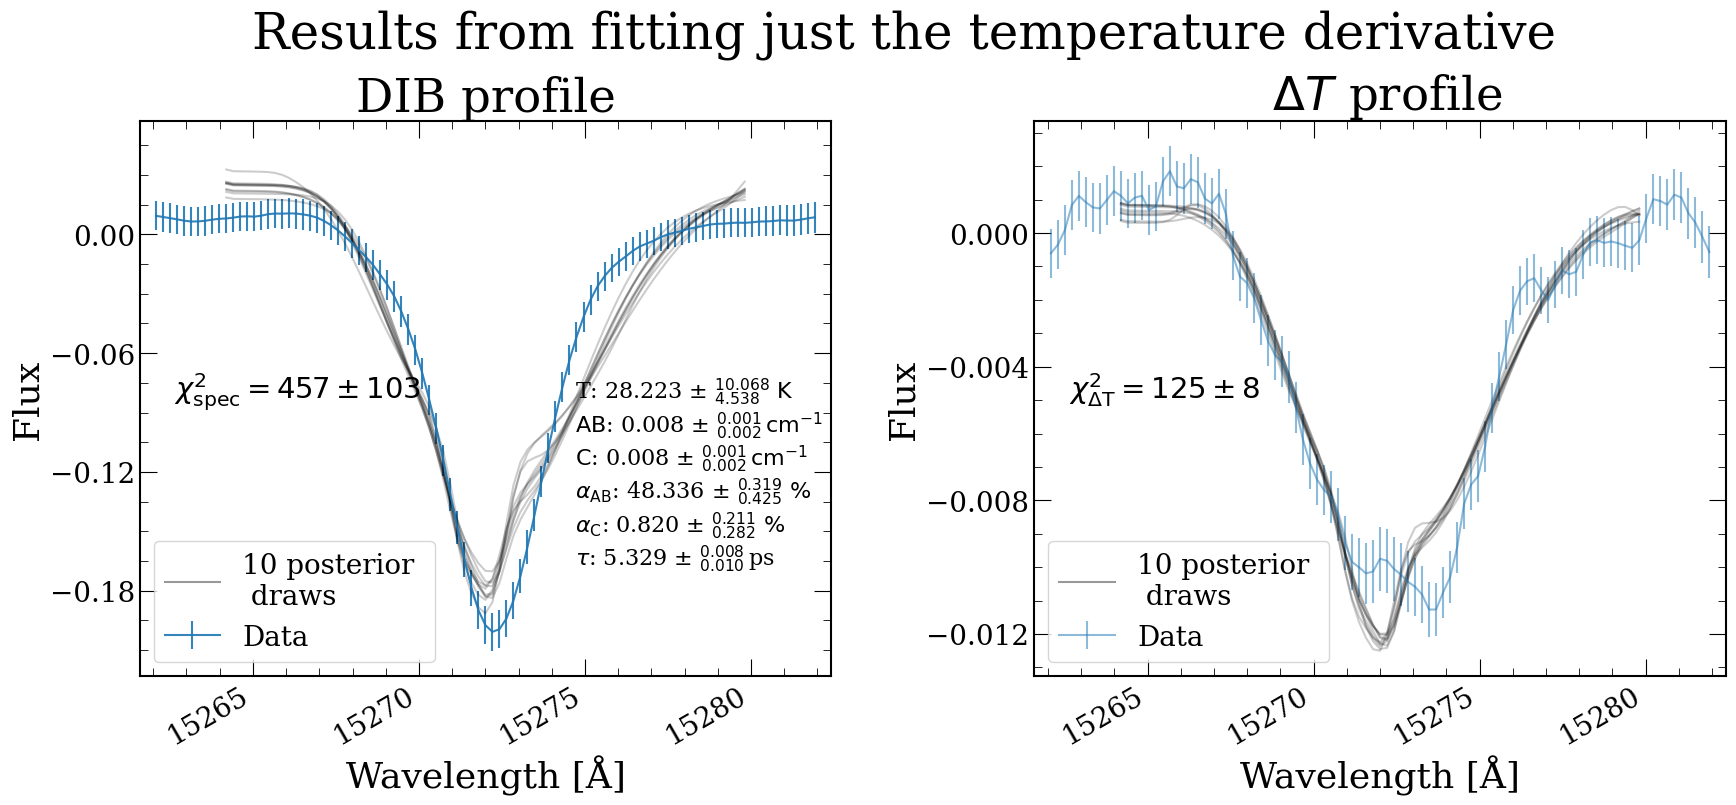

In [15]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=False)
plt.rc("font", family="serif",size= 28)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=26)
plt.rc("xtick", labelsize=20, direction="in")
plt.rc("ytick", labelsize=20, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=20)

plt.close('all')
fig, axs = plt.subplots(ncols = 2, figsize= (18,9))
c = 10
# c = 30

print(filename)

dwav = -0.5
xlim = (data_wavelength[0]+dwav, data_wavelength[-1]-dwav)
n_yticks = n_xticks = 5
legend_location = 'lower left'
alpha_post = 0.2

chi2 = ( (posterior_spectra.T-data_flux[c:-c].reshape(-1, 1) )/noise_std[c:-c].reshape(-1, 1))**2
chi2 = np.sum(chi2, axis = 0)

Ntop = 10

DIB_label = ''
posterior_label = f'{Ntop} posterior \n draws'

# indices of the N smallest values
idx = np.argpartition(chi2, Ntop)[:Ntop]
# if you want them sorted by value
spec_min_idx = idx[np.argsort(chi2[idx])]

chi2_dT = ( (posterior_dT.T-data_flux_dT[c:-c].reshape(-1, 1) )/noise_std_dT[c:-c].reshape(-1, 1))**2
chi2_dT = np.sum(chi2_dT, axis = 0)
# indices of the N smallest values
idx = np.argpartition(chi2_dT, Ntop)[:Ntop]
# if you want them sorted by value
dT_min_idx = idx[np.argsort(chi2_dT[idx])]

axs[0].errorbar(data_wavelength, data_flux, yerr = noise_std, alpha = 0.9, label = 'Data')
axs[0].plot(data_wavelength[c:-c], posterior_spectra.T[:, spec_min_idx], 'k-', alpha = alpha_post)
axs[0].plot(data_wavelength[c:-c]-100, posterior_spectra[0], 'k-', alpha = 2*alpha_post, label = posterior_label)

axs[0].set(xlabel = 'Wavelength [Å]', ylabel = 'Flux', title = 'DIB profile', xlim = xlim )
axs[0].legend(loc = legend_location)

axs[1].errorbar(data_wavelength, data_flux_dT, yerr = noise_std_dT, alpha = 0.5, label = 'Data')
axs[1].plot(data_wavelength[c:-c], posterior_dT.T[:, dT_min_idx], 'k-', alpha = alpha_post)
axs[1].plot(data_wavelength[c:-c]-100, posterior_dT[0], 'k-', alpha = 2*alpha_post, label = posterior_label)
axs[1].set(xlabel = 'Wavelength [Å]', ylabel = 'Flux', title = r' $\Delta T$ profile', xlim = xlim )
axs[1].legend(loc = legend_location)

plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

axs[0].xaxis.set_major_locator(plt.MaxNLocator(n_xticks))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(n_xticks))

axs[0].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))

labels = [r'$\tau$', r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T']
units = ['$~\mathrm{K}$']+[r'$\,\mathrm{cm}^{-1}$']*3+[r'$~\%$']*3

x0, y0 = 0.63, 0.5
dy = 0.06
# for i, l in enumerate(labels[::-1]):
    
#     s = np.copy(samples[inds,i])
#     if i ==0:
#         s*=T_fac        
#     if i>3 and i<7:
#         s = (1-s)/2
#         s*=100
#     if i==7:
#         s *= 2.998e10 # from inv cm to Hz
#         s = 1/(2*np.pi*s)

#         if np.median(s)>1e-10:
#             s *=1e9
#             units += [r'$\,$ns']
#         else:
#             s *=1e12
#             units += [r'$\,$ps']
#     med = np.median(s)
#     uperr = np.percentile(s, 84)-med
#     downerr = med - np.percentile(s, 16)
#     text = fr"{l}: {med:.3f} $\pm$ $^{{{uperr:.3f}}}_{{{downerr:.3f}}}$"+units[i]
#     axs[0].annotate(text, xy = (x0, y0-i*dy), xycoords = 'axes fraction', fontsize = 16)

labels = [r'$\tau$', r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T']
units = ['$~\mathrm{K}$']+[r'$\,\mathrm{cm}^{-1}$']*2+[r'$~\%$']*2
for i, l in enumerate(labels[::-1]):
    
    s = np.copy(samples[inds,i])
    if i ==0:
        s*=T_fac        
    if i>2 and i<5:
        s = (1-s)/2
        s*=100
    if i==5:
        s *= 2.998e10 # from inv cm to Hz
        s = 1/(2*np.pi*s)

        if np.median(s)>1e-10:
            s *=1e9
            units += [r'$\,$ns']
        else:
            s *=1e12
            units += [r'$\,$ps']
    med = np.median(s)
    uperr = np.percentile(s, 84)-med
    downerr = med - np.percentile(s, 16)
    text = fr"{l}: {med:.3f} $\pm$ $^{{{uperr:.3f}}}_{{{downerr:.3f}}}$"+units[i]
    axs[0].annotate(text, xy = (x0, y0-i*dy), xycoords = 'axes fraction', fontsize = 16)

x0, y0 = 0.7, 0.47
dx = 0.06
dy = 0.065
# i = 4.5
# axs[1].annotate(fr'$\frac{{df}}{{dR(V)}} = {np.mean(dDIBdRV):.2f} \pm {np.std(dDIBdRV)/np.sqrt(len(dDIBdRV)):.2f}$', xy = (x0-dx, y0-i*dy), xycoords = 'axes fraction', fontsize = 19)
# i = 6
# axs[1].annotate(fr'$\frac{{dT}}{{dR(V)}} = {np.mean(beta_prime):.0f} \pm {np.std(beta_prime)/1:.0f}\,\mathrm{{K}}$', xy = (x0-dx, y0-i*dy), xycoords = 'axes fraction', fontsize = 19)


x0, y0 = 0.05, 0.5
dy = 0.09
fs = 21
annotate_total= False

divf = np.sqrt(len(chi2))
divf = 1
chi2 = chi2[spec_min_idx]
chi2_dT = chi2_dT[dT_min_idx]
axs[0].annotate(fr'$\chi^2_{{\mathrm{{spec}}}} = {np.mean(chi2):.0f} \pm {np.std(chi2)/divf:.0f}$', xy = (x0, y0),\
                xycoords = 'axes fraction', fontsize = fs)
if annotate_total:
    axs[0].annotate(fr'$\chi^2_{{\mathrm{{tot}}}} = {np.mean(chi2+chi2_dT):.0f} \pm {np.std(chi2+chi2_dT)/divf:.0f}$', xy = (x0, y0-dy),\
                    xycoords = 'axes fraction', fontsize = fs)

axs[1].annotate(fr'$\chi^2_{{\mathrm{{\Delta T}}}} = {np.mean(chi2_dT):.0f} \pm {np.std(chi2_dT)/divf:.0f}$', xy = (x0, y0),\
                xycoords = 'axes fraction', fontsize = fs)
if annotate_total:
    axs[1].annotate(fr'$\chi^2_{{\mathrm{{tot}}}} = {np.mean(chi2+chi2_dT):.0f} \pm {np.std(chi2+chi2_dT)/divf:.0f}$', xy = (x0, y0-dy),\
                    xycoords = 'axes fraction', fontsize = fs)


title_add = ''
if args.fit_spec:
    title_add += 'the DIB profile'
    if args.fit_dT:
        title_add += ' AND the temperature derivative'
    else:
        title_add = 'just ' + title_add
if args.fit_dT and not args.fit_spec:
    title_add += 'just the temperature derivative'
    
fig.suptitle(f'Results from fitting {title_add}', y = 0.92, x = 0.52, fontsize = 36)

fig.tight_layout()
name = ''
if args.fit_spec:
    name += '_spec'
if args.fit_dT:
    name+='_dT'
    
# fig.savefig(f'figs/data_and_model{name}.png', dpi = 200, bbox_inches = 'tight')

fig

In [93]:
# from matplotlib.ticker import LogLocator, FuncFormatter
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams["figure.facecolor"] = "white"
# plt.rc("text", usetex=False)
# plt.rc("font", family="serif",size= 17)
# plt.rc("axes", linewidth=1.5)
# plt.rc("axes", labelsize=22)
# plt.rc("xtick", labelsize=16, direction="in")
# plt.rc("ytick", labelsize=16, direction="in")
# plt.rc("xtick", top=True)
# plt.rc("ytick", right=True)
# plt.rc("xtick.minor", visible=True)
# plt.rc("ytick.minor", visible=True)
# plt.rc("xtick.major",size=10, pad=6)
# plt.rc("xtick.minor",size=4, pad=6)
# plt.rc("ytick.major",size=10)
# plt.rc("ytick.minor",size=4)
# plt.rc("legend", fontsize=20)

# # samples_ext = samples[samples[:,0]>10]
# # samples = np.vstack([samples, samples_ext, samples_ext, samples_ext])
# print(f"Samples shape: {samples.shape}")

# labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T']
# # Corner plot

# samples0 = np.copy(samples)
# samples0[:,[4,5,6]] = (1-samples0[:,[4,5,6]])/2*100
# axes_scale = ['log']+6*['linear']
# # axes_scale = 7*['linear']

# fig, axs = plt.subplots(7, 7, figsize = ( 18, 18 )) 

# fig = corner.corner(
#     samples0,
#     labels=labels[::-1],
#     bins = 25,
#     axes_scale = axes_scale,
#     show_titles=True,
#     smooth = 1,
#     quantiles=[0.16, 0.5, 0.84],
#     title_fmt=".3f",
#     range = [0.999999]*len(labels),
#     use_math_text = True,
#     labelpad = 0.02,
#     fig = fig
# )

# # for ax in fig.get_axes():
# #     for label in ax.get_xticklabels():
# #         label.set_rotation(10)



# # Target the correct axis (here, axis #6, which is the bottom-left corner for param 0)
# ax = fig.axes[-7]

# # Choose your desired tick positions in linear space
# if args.fit_spec:
#     tick_positions = [3, 4, 6, 10, 17]
#     if args.fit_dT:
#         tick_positions = [3, 4, 6, 10, 13]    
        
# if args.fit_dT and not args.fit_spec:
#     tick_positions = [4, 10, 20, 40]    
    
# # Apply to log-scaled axis using LogLocator and manually set labels
# ax.set_xticks(tick_positions)
# ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))

# fig.suptitle(f'Results from fitting \n {title_add}', y = 0.92, x = 0.65, fontsize = 32)

# plt.draw()
# name = ''
# if args.fit_spec:
#     name += '_spec'
# if args.fit_dT:
#     name+='_dT'
# fig.savefig(f'figs/emcee{name}.png', dpi = 200, bbox_inches = 'tight')
# fig

In [94]:
# list_fits = os.listdir('temp_outputs')
# list_fits = [l[-9:-4] for l in list_fits]

# idx = 10

# spec = np.loadtxt(f'temp_outputs/fit_spec_{list_fits[idx]}.csv')
# spec, specb, specc, dT, dTb, dTc = spec
# # specb = np.loadtxt(f'temp_outputs/specb_{list_fits[idx]}.csv')
# # specc = np.loadtxt(f'temp_outputs/specc_{list_fits[idx]}.csv')
# # dT = np.loadtxt(f'temp_outputs/fit_dt_{list_fits[idx]}.csv')

# fig, axs = plt.subplots(ncols = 2, figsize = (12,6))
# c = 10
# axs[0].plot(specb)

# axs[0].plot(specc)
# axs[0].plot(spec)
# axs[0].plot(data_flux[c:-c])

# axs[1].plot(dT)
# axs[1].plot(dTb)
# axs[1].plot(dTc)
# axs[1].plot(data_flux_dT[c:-c])